In [8]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import random
import pandas as pd
import math
import time
import joblib

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP, FixedNoiseGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch.utils.multi_objective.hypervolume import infer_reference_point
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, WhiteKernel

# pymoo dependencies
import pymoo

from pymoo.factory import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
from pymoo.core.repair import Repair

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d, Axes3D

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

###########
from skopt.space import Space
from skopt.sampler import Lhs

In [9]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, standard_bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts if q candidates fail to show improvement
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )
        
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # repair inputs wrt to 100% sum
        for i in range(new_x.shape[0]):
            new_x[i] = new_x[i]/new_x[i].sum()

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, standard_bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_x_gp, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

class MyRepair(Repair):

    def _do(self, problem, pop, **kwargs):
        for k in range(len(pop)):
            x = pop[k].X
            x = x/x.sum()

        return pop

def optimize_nsga3(problem, ref_point, initial_x, # must haves
                   N_BATCH, pop_size,
                   ref_num=10, # as a rule of thumb, pop_size>ref_num,
                   noise=0, random_state=np.random.randint(0, 1000000, (1,)).item(), verbose=False):
    
    print("Optimizing with NSGA-III")
    
    t0 = time.time()    
    
    # some initializing
    hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    
    noise=noise

    # define a pymoo problem class based on the torch class
    class PymooProblem(ElementwiseProblem):

        def __init__(self):
            super().__init__(n_var=problem.n_var,
                             n_obj=problem.n_obj,
                             n_constr=problem.n_constr,
                             xl=problem.bounds[0].cpu().numpy(),
                             xu=problem.bounds[1].cpu().numpy())

        def _evaluate(self, X, out, *args, **kwargs):
            # base input/output from torch class
            train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)
            
            # take the noisy observations for algo
            train_obj, train_con = problem.evaluate(train_x)
            train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
            train_con_noisy = train_con + noise*torch.randn_like(train_con)

            # output the noisy observations instead
            out["F"] = -train_obj_noisy.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
            out["G"] = train_con_noisy.cpu().numpy()
            
    ##########        

    pymooproblem = PymooProblem()

    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("energy", problem.n_obj, ref_num, seed=random_state)
    
    # initial sampling
    sampling = initial_x.cpu().numpy()
    
    # create the algorithm object
    algorithm = NSGA3(pop_size=pop_size,
                      ref_dirs=ref_dirs,
                      sampling=sampling,
                      repair=MyRepair(),
                     )

    # execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
    res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH+1),
                   verbose=verbose, save_history=True)
    
    ##########
    
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")
    
    ##########
    
    # convert population data into tensor form
    # initial data
    train_x = torch.tensor(res.history[0].pop.get("X").tolist(), **tkwargs)
    train_obj, train_con = problem.evaluate(train_x) 
    # population at each iteration
    for i in range(1,N_BATCH+1): # don't forget we did +1 for total iterations
        new_x = torch.tensor(res.history[i].pop.get("X").tolist(), **tkwargs)
        new_obj, new_con = problem.evaluate(new_x)
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])

    ##########
        
    # calculate hypervolume based on checks, done on noiseless train_obj and train_con
    iterdict = {}
    a = 0
    b = N_BATCH
    for i in range(0, N_BATCH+1):

        iterdict[i] = (a, b)
        # a stays at zero
        b+=pop_size
    
    for i in range(0,N_BATCH):
        hvs_obj = train_obj[iterdict[i][0]:iterdict[i][1]]
        hvs_con = train_con[iterdict[i][0]:iterdict[i][1]]

        is_feas = (hvs_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = hvs_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)

    print("DONE!\n")
        
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [10]:
gp_dict = joblib.load('gp_dict ')
xscaler = joblib.load('xscaler')
yscaler = joblib.load('yscaler')

df = pd.read_csv('data.csv')

target_dict = {'CS': 'Compression Strength (MPa)',
               'CM': 'Compression Modulus (MPa)', 
               'TS': 'Toughness (GPa)'
              }

x_list = df.columns[3:]
obj_list = df.columns[:3]
X_train = df[x_list].to_numpy()
y_train = df[obj_list].to_numpy()

df

,Compression Strength (MPa),Compression Modulus (MPa),Toughness (GPa),A (wt%),B (wt%),C (wt%),D (wt%),E (wt%),F (wt%)
0,455,1.37,68113,0,18,21,28,20,13
1,280,2.11,51731,0,2,38,4,29,27
2,470,1.76,77877,19,30,10,6,7,28
3,440,1.96,76655,8,16,14,4,19,39
4,366,1.23,62118,34,6,23,16,19,2
...,...,...,...,...,...,...,...,...,...
138,558,1.15,81235,34,36,0,0,20,10
139,500,1.68,86776,39,23,0,0,0,38
140,502,1.65,86185,37,22,0,1,0,40
141,498,1.68,87186,41,21,0,1,0,37


In [11]:
'''
setting the reference point using botorch's utility
this takes the 0.1 + range from nadir point of the pareto front

we won't use this because our outputs have been scaled
'''

torch_y = torch.tensor(y_train, **tkwargs)
pareto_mask = is_non_dominated(torch_y)
pareto_y = torch_y[pareto_mask]
real_ref_point = infer_reference_point(pareto_y)
real_ref_point

tensor([2.691e+02, 9.170e-01, 6.519e+04], device='cuda:0', dtype=torch.float64)

In [12]:
'''
define the problem statement and objective function, using the regressor we previously trained
although there exists tool to infer ref point, we can take origin 0 as a good start
this is also what the paper did
'''

lowerbound = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], **tkwargs)
upperbound = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], **tkwargs)

class Problem(torch.nn.Module):
    # must define these!
    n_var = 6
    n_obj = 3
    n_constr = 1
    
    ref_point = torch.tensor([0, 0, 0], **tkwargs)
        
    # input bounds, don't forget to change according to n_var! 
    bounds = torch.vstack([lowerbound,upperbound])
    
    def evaluate(X):
        X_np = X.cpu().numpy() 
        
        y1 = gp_dict['CS'].predict(X_np)
        y2 = gp_dict['CM'].predict(X_np)
        y3 = gp_dict['TS'].predict(X_np)
        
        y_combined = np.stack([y1,y2,y3], axis=1)
        output = torch.tensor(y_combined, **tkwargs)
        slack = (torch.sum(X, dim=1) - 1)**2 - 0.001 # we add an epilson of 0.1% 
        
        return output, slack.unsqueeze(dim=-1)

In [6]:
'''
we assume here that the constraints are NOT black-box, but enforceable and known to user
we proceed to randomly generate 30 virtual samples using LHS, and then 'repair' them to 100%

'''

lhs = Lhs(criterion="maximin", iterations=1000)
space = Space([(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)])
lhs_x = lhs.generate(space.dimensions, 30)

# enforce 100% sum
lhs_x = np.array(lhs_x)
for i in range (lhs_x.shape[0]):
    lhs_x[i] = lhs_x[i]/(lhs_x[i].sum()/1)
    
y1 = gp_dict['CS'].predict(lhs_x)
y2 = gp_dict['CM'].predict(lhs_x)
y3 = gp_dict['TS'].predict(lhs_x)
        
initial_y = np.stack([y1,y2,y3], axis=1)
real_y = yscaler.inverse_transform(initial_y)

Text(0.5, 0, 'Toughness (GPa)')

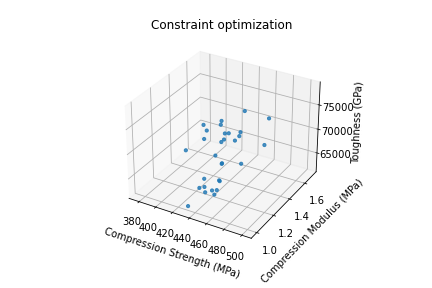

In [7]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(real_y[:,0],
             real_y[:,1],
             real_y[:,2],
             s=10, alpha=0.8)
'''
ax.scatter3D(real_ref_point.cpu().numpy()[0],
             real_ref_point.cpu().numpy()[1], 
             real_ref_point.cpu().numpy()[2],
             c="r", s=100, marker="*")
'''
ax.set_title(f"Constraint optimization")
ax.set_xlabel('Compression Strength (MPa)', fontsize=10)
ax.set_ylabel('Compression Modulus (MPa)', fontsize=10)
ax.set_zlabel('Toughness (GPa)', fontsize=10)

In [8]:
'''
Now, we perform optimization, the paper originally did an additional 120 evaluations, but lets try 160-240
within the function, we have included a repair operator to 'force' feasibility
this was inspired by shakti's work on scaling of ratio combinations, and also riko's work for metals
however, this should not be relied on as scaling is never perfect
thats why the original constraint is still in play for the algo to optimize

taking our learnings from the synthethic benchmarks:
low throughput for BO, and high throughput for EA
'''

initial_x = torch.tensor(lhs_x, **tkwargs)


hvs_qnehvi, train_qnehvi = optimize_qnehvi(Problem, Problem.ref_point, initial_x,
                                           N_BATCH=40, BATCH_SIZE=2,
                                           random_state=1, noise=0, verbose=True)


hvs_nsga3, train_nsga3 = optimize_nsga3(Problem, Problem.ref_point, initial_x,
                                        N_BATCH=10, pop_size=8, ref_num=8,
                                        random_state=1, noise=0, verbose=True)

Optimizing with qNEHVI


D:\Anaconda\lib\site-packages\botorch\fit.py:143: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is C:\Users\Andre\AppData\Local\Temp/torch/kernels. This warning will appear only once per process. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cuda\jit_utils.cpp:860.)
  warnings.warn(w.message, w.category)
D:\Anaconda\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solutio

Batch  1 of 40: Hypervolume = 0.29, time = 9.78s.
Batch  2 of 40: Hypervolume = 0.30, time = 9.16s.
Batch  3 of 40: Hypervolume = 0.33, time = 8.32s.
Batch  4 of 40: Hypervolume = 0.33, time = 10.09s.
Batch  5 of 40: Hypervolume = 0.34, time = 10.19s.
Batch  6 of 40: Hypervolume = 0.34, time = 10.39s.
Batch  7 of 40: Hypervolume = 0.34, time = 12.43s.
Batch  8 of 40: Hypervolume = 0.35, time = 10.68s.
Batch  9 of 40: Hypervolume = 0.38, time = 12.37s.
Batch 10 of 40: Hypervolume = 0.39, time = 10.88s.
Batch 11 of 40: Hypervolume = 0.39, time = 11.07s.
Batch 12 of 40: Hypervolume = 0.39, time = 12.32s.
Batch 13 of 40: Hypervolume = 0.39, time = 15.03s.
Batch 14 of 40: Hypervolume = 0.40, time = 13.37s.
Batch 15 of 40: Hypervolume = 0.40, time = 15.54s.
Batch 16 of 40: Hypervolume = 0.40, time = 17.52s.
Batch 17 of 40: Hypervolume = 0.40, time = 13.42s.
Batch 18 of 40: Hypervolume = 0.40, time = 14.43s.
Batch 19 of 40: Hypervolume = 0.40, time = 18.83s.
Batch 20 of 40: Hypervolume = 0.40

Text(0.5, 1.0, 'Iteration')

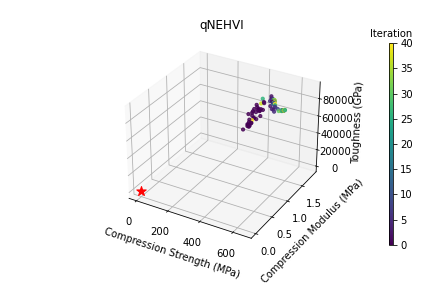

In [9]:
N_BATCH = 40
BATCH_SIZE = 2

batch_number = torch.cat([torch.zeros(30),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

real_obj = yscaler.inverse_transform(train_qnehvi[...,Problem.n_var:Problem.n_var+Problem.n_obj])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(real_obj[:,0],
             real_obj[:,1],
             real_obj[:,2],
             c=batch_number, s=10, alpha=0.8)

ax.scatter3D(Problem.ref_point.cpu().numpy()[0],
             Problem.ref_point.cpu().numpy()[1], 
             Problem.ref_point.cpu().numpy()[2],
             c="r", s=100, marker="*")

ax.set_title(f"qNEHVI")
ax.set_xlabel('Compression Strength (MPa)', fontsize=10)
ax.set_ylabel('Compression Modulus (MPa)', fontsize=10)
ax.set_zlabel('Toughness (GPa)', fontsize=10)
#axes[i].set_xlim(obj1min, obj1max)
#axes[i].set_ylim(obj2min, obj2max)

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
#fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=10)

Text(0.5, 1.0, 'Iteration')

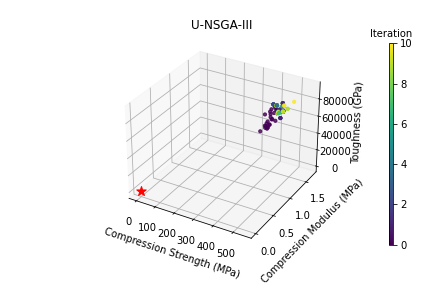

In [11]:
N_BATCH = 10
BATCH_SIZE = 8

batch_number = torch.cat([torch.zeros(30),
                          torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)
                         ]).numpy()

real_obj = yscaler.inverse_transform(train_nsga3[...,Problem.n_var:Problem.n_var+Problem.n_obj])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter3D(real_obj[:,0],
             real_obj[:,1],
             real_obj[:,2],
             c=batch_number, s=10, alpha=0.8)

ax.scatter3D(Problem.ref_point.cpu().numpy()[0],
             Problem.ref_point.cpu().numpy()[1], 
             Problem.ref_point.cpu().numpy()[2],
             c="r", s=100, marker="*")

ax.set_title(f"U-NSGA-III")
ax.set_xlabel('Compression Strength (MPa)', fontsize=10)
ax.set_ylabel('Compression Modulus (MPa)', fontsize=10)
ax.set_zlabel('Toughness (GPa)', fontsize=10)
#axes[i].set_xlim(obj1min, obj1max)
#axes[i].set_ylim(obj2min, obj2max)

norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
#fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([0.9, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration", fontsize=10)

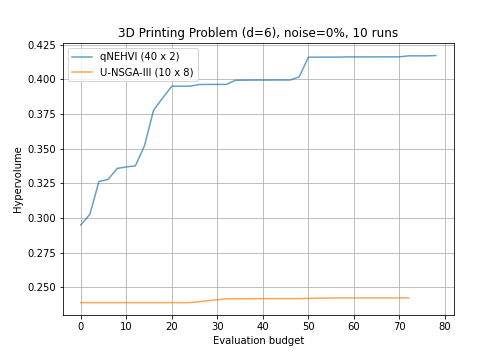

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

    
ax.plot(np.arange(40)*2,
        np.array(hvs_qnehvi),
        label=f'qNEHVI (40 x 2)', linewidth=1.5, alpha=0.7)

'''ax.fill_between(np.arange(iteration),
                hv.mean(axis=0)-ci(hv, 10), hv.mean(axis=0)+ci(hv, 10),
                alpha=0.3)'''

ax.plot(np.arange(10)*8,
        np.array(hvs_nsga3),
        label=f'U-NSGA-III (10 x 8)', linewidth=1.5, alpha=0.7)

'''ax.fill_between(np.arange(iteration),
                hv.mean(axis=0)-ci(hv, 10), hv.mean(axis=0)+ci(hv, 10),
                alpha=0.3)'''
        
ax.set(xlabel='Evaluation budget')
ax.grid(True)
ax.set_title(f"3D Printing Problem (d=6), noise=0%, 10 runs")
 
ax.set(ylabel='Hypervolume')
ax.legend(loc='best')

In [16]:
N_BATCH = 200
pop_size = 100
random_state = 1
verbose = True

ref_point = torch.tensor([0, 0, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
hvs = [] # create a blank array to append the scores at each batch/iteration for that run

problem = Problem

# define a pymoo problem class based on the torch class
class PymooProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=problem.n_var,
                         n_obj=problem.n_obj,
                         n_constr=problem.n_constr,
                         xl=problem.bounds[0].cpu().numpy(),
                         xu=problem.bounds[1].cpu().numpy())

    def _evaluate(self, X, out, *args, **kwargs):
        # base input/output from torch class
        train_x = torch.tensor(X.tolist(), **tkwargs).unsqueeze(dim=0)

        # take the noisy observations for algo
        train_obj, train_con = problem.evaluate(train_x)

        # output the noisy observations instead
        out["F"] = -train_obj.cpu().numpy() # flip since botorch assumes maximisation vs pymoo minimization
        out["G"] = train_con.cpu().numpy()

##########        

pymooproblem = PymooProblem()

# create the algorithm object
algorithm = NSGA2(pop_size=pop_size,
                  sampling=get_sampling('real_lhs'),
                 )

# execute the optimization, take N_BATCH+1 since 1st iteration is just the initial sampling
res = minimize(pymooproblem, algorithm, seed=random_state, termination=('n_gen', N_BATCH),
               verbose=verbose, save_history=True)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.491691048 |  4.421913715 |       1 |            - |            -
    2 |     200 |  0.004374044 |  1.882197039 |       1 |  0.046172574 |        ideal
    3 |     300 |  0.001392252 |  0.919811028 |       1 |  0.017867276 |        ideal
    4 |     400 |  0.00000E+00 |  0.305291796 |       1 |  0.186137120 |        ideal
    5 |     500 |  0.00000E+00 |  0.069050597 |       4 |  1.065632873 |        ideal
    6 |     600 |  0.00000E+00 |  0.015249154 |       7 |  0.103341560 |        ideal
    7 |     700 |  0.00000E+00 |  0.003812592 |      11 |  0.148444625 |        ideal
    8 |     800 |  0.00000E+00 |  0.001108394 |      15 |  0.058591425 |        ideal
    9 |     900 |  0.00000E+00 |  0.000209536 |       9 |  0.536101649 |        ideal
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |      17 |  0.067467127 |        ideal
   11 |    1100 |  0.00000E+00 |  0.00000E+00 |      1

   95 |    9500 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001713247 |            f
   96 |    9600 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001181770 |            f
   97 |    9700 |  0.00000E+00 |  0.00000E+00 |      99 |  0.001007277 |            f
   98 |    9800 |  0.00000E+00 |  0.00000E+00 |     100 |  0.004741651 |        ideal
   99 |    9900 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001201690 |            f
  100 |   10000 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000822804 |            f
  101 |   10100 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001076330 |            f
  102 |   10200 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001092025 |            f
  103 |   10300 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000884925 |            f
  104 |   10400 |  0.00000E+00 |  0.00000E+00 |     100 |  0.006785422 |        ideal
  105 |   10500 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000481000 |            f
  106 |   10600 |  0.00000E+00 |  0.00000E+00 |     10

  191 |   19100 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000561225 |            f
  192 |   19200 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000297883 |            f
  193 |   19300 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000588191 |            f
  194 |   19400 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000400000 |            f
  195 |   19500 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000223506 |            f
  196 |   19600 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000474050 |            f
  197 |   19700 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000448867 |            f
  198 |   19800 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000589075 |            f
  199 |   19900 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000501645 |            f
  200 |   20000 |  0.00000E+00 |  0.00000E+00 |     100 |  0.000469884 |            f


In [18]:
##########

# convert population data into tensor form
# initial data
train_x = torch.tensor(res.history[-1].pop.get("X").tolist(), **tkwargs)
train_obj, train_con = problem.evaluate(train_x) 

##########

# calculate hypervolume based on checks, done on noiseless train_obj and train_con

is_feas = (hvs_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
feas_train_obj = hvs_obj[is_feas] # take only points that fit the 1st check
if feas_train_obj.shape[0] > 0:
    pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
    pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
    volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
else:
    volume = 0.0

hvs.append(volume)

hvs

[0.7339605119112032]

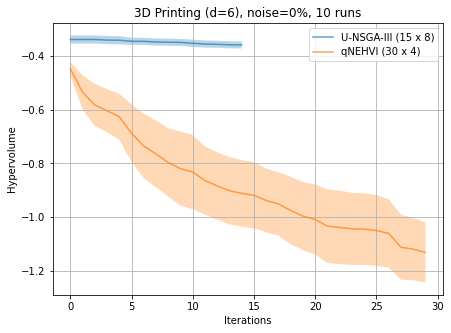

In [19]:
hvs_nsga3_all0 = loadtxt(f"3Dprinting_hvs_nsga3_15by8.csv", delimiter=',')
hvs_nsga3_all = np.log10(0.7339605119112032-hvs_nsga3_all0)

hvs_qnehvi_all0 = loadtxt(f"3Dprinting_hvs_qnehvi_30by4.csv", delimiter=',')
hvs_qnehvi_all = np.log10(0.7339605119112032-hvs_qnehvi_all0)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(np.arange(15),
        hvs_nsga3_all.mean(axis=0),
        label=f'U-NSGA-III (15 x 8)', linewidth=1.5, alpha=0.7)

ax.fill_between(np.arange(15),
                hvs_nsga3_all.mean(axis=0)-ci(hvs_nsga3_all, 10), hvs_nsga3_all.mean(axis=0)+ci(hvs_nsga3_all, 10),
                alpha=0.3)  

ax.plot(np.arange(30),
        hvs_qnehvi_all.mean(axis=0),
        label=f'qNEHVI (30 x 4)', linewidth=1.5, alpha=0.7)

ax.fill_between(np.arange(30),
                hvs_qnehvi_all.mean(axis=0)-ci(hvs_qnehvi_all, 10), hvs_qnehvi_all.mean(axis=0)+ci(hvs_qnehvi_all, 10),
                alpha=0.3)

ax.grid(True)

ax.set(xlabel='Iterations')
ax.set_title(f"3D Printing (d=6), noise=0%, 10 runs")
ax.set(ylabel='Hypervolume')
ax.legend(loc="best")